<a href="https://colab.research.google.com/github/aggelospsiris/Data-mining-and-Learning-Algorithms/blob/main/lstm/second.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import os

In [4]:
#Add every csv into a dataframe and in every row add the date that is gonna be a crusial input for the lstm

### Demands ###

df_dmd = pd.DataFrame()
for file1 in os.listdir("/content/drive/MyDrive/Colab Notebooks/demand"):
    try:
        current_demand = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/demand/" + file1)
        current_demand["Date"] = pd.to_datetime(file1[0:8], format='%Y%m%d')
        df_dmd = df_dmd.append(current_demand, ignore_index=False)
    except:
        continue

df_dmd.Time = pd.to_datetime(df_dmd.Time)

### Sources ###

df_sources = pd.DataFrame()
for file2 in os.listdir("/content/drive/MyDrive/Colab Notebooks/sources"):
    try:
        current_source = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sources/" + file2)
        current_source["Date"] = pd.to_datetime(file2[0:8], format='%Y%m%d')
        df_sources = df_sources.append(current_source, ignore_index=False)
    except:
        continue

df_sources.Time = pd.to_datetime(df_sources.Time)


In [5]:
#As we can see from these results some files from the sources folder have empty values
#so our try,except block ignores the empty files
#So the two dataframes havent the same size so we are going to have a problem merging them
#I fix this issue by adding on more column to the dataframe thats is the date 
#So i am merging them by day AND time and not only time  
print(df_dmd.shape)
print(df_sources.shape)



(316744, 5)
(315641, 17)


In [6]:
### Merge the two datasets ###
df3 = pd.merge(df_sources, df_dmd, on=["Time","Date"])
print(df3.shape)
print("------------------------------------------")
print(df3.head())


(316748, 20)
------------------------------------------
                 Time  Solar    Wind  Geothermal  Biomass  Biogas  \
0 2022-05-31 00:00:00    0.0  2762.0       960.0    259.0   225.0   
1 2022-05-31 00:00:00    0.0  2762.0       960.0    259.0   225.0   
2 2022-05-31 00:05:00    0.0  2737.0       960.0    257.0   225.0   
3 2022-05-31 00:10:00    0.0  2721.0       959.0    257.0   225.0   
4 2022-05-31 00:15:00    0.0  2709.0       961.0    256.0   224.0   

   Small hydro  Coal  Nuclear  Natural gas  Large hydro  Batteries  Imports  \
0        475.0  10.0   2279.0       3145.0       3458.0       -1.0   6858.0   
1        475.0  10.0   2279.0       3145.0       3458.0       -1.0   6858.0   
2        476.0  10.0   2280.0       2989.0       3446.0       10.0   6945.0   
3        475.0  10.0   2279.0       2942.0       3457.0        0.0   6875.0   
4        458.0  10.0   2280.0       3028.0       3421.0      -35.0   6824.0   

   Other       Date  Natural Gas  Large Hydro  Day ahe

In [7]:
#'Large Hydro', 'Natural Gas' had nan values also the lstm has to guess the non renewable resources so i dont need them as input 
#So i am going to drop these columns
#Also the Day ahead forecast and the Hour ahead forecast are not useful nor as inputs not as outputs on the lstm
df3 = df3.drop(['Large Hydro', 'Natural Gas','Nuclear','Batteries','Day ahead forecast','Hour ahead forecast'], axis=1)
print(df3.head())

                 Time  Solar    Wind  Geothermal  Biomass  Biogas  \
0 2022-05-31 00:00:00    0.0  2762.0       960.0    259.0   225.0   
1 2022-05-31 00:00:00    0.0  2762.0       960.0    259.0   225.0   
2 2022-05-31 00:05:00    0.0  2737.0       960.0    257.0   225.0   
3 2022-05-31 00:10:00    0.0  2721.0       959.0    257.0   225.0   
4 2022-05-31 00:15:00    0.0  2709.0       961.0    256.0   224.0   

   Small hydro  Coal  Natural gas  Large hydro  Imports  Other       Date  \
0        475.0  10.0       3145.0       3458.0   6858.0    0.0 2019-04-08   
1        475.0  10.0       3145.0       3458.0   6858.0    0.0 2019-04-08   
2        476.0  10.0       2989.0       3446.0   6945.0    0.0 2019-04-08   
3        475.0  10.0       2942.0       3457.0   6875.0    0.0 2019-04-08   
4        458.0  10.0       3028.0       3421.0   6824.0    0.0 2019-04-08   

   Current demand  
0         20400.0  
1             NaN  
2         20315.0  
3         20200.0  
4         20145.0  


In [8]:
#Now i have to convert date and time into a better input for my lstm 
#In a timestamp format is not gonna give any help to the lstm
#I need to convert it in a form that january is close to december and 23:55 is near to 00:05
#So i am using sin and cosine to format my values in a circle
#Also the year is not gonna be usufull so i am not keeping it
df3['month'] = df3.Date.dt.month
df3['day'] = df3.Date.dt.day
df3['hour'] = df3.Time.dt.hour
df3['minute'] = df3.Time.dt.minute
df3 = df3.drop(['Time','Date'],axis=1)

In [9]:
df3.head()

,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Natural gas,Large hydro,Imports,Other,Current demand,month,day,hour,minute
0,0.0,2762.0,960.0,259.0,225.0,475.0,10.0,3145.0,3458.0,6858.0,0.0,20400.0,4,8,0,0
1,0.0,2762.0,960.0,259.0,225.0,475.0,10.0,3145.0,3458.0,6858.0,0.0,NaN,4,8,0,0
2,0.0,2737.0,960.0,257.0,225.0,476.0,10.0,2989.0,3446.0,6945.0,0.0,20315.0,4,8,0,5
3,0.0,2721.0,959.0,257.0,225.0,475.0,10.0,2942.0,3457.0,6875.0,0.0,20200.0,4,8,0,10
4,0.0,2709.0,961.0,256.0,224.0,458.0,10.0,3028.0,3421.0,6824.0,0.0,20145.0,4,8,0,15


In [10]:
#Converting the values into cos and sin values
# Month
df3['day_sin'] = np.sin(df3.month*(2.*np.pi/12))
df3['day_cos'] = np.cos(df3.month*(2.*np.pi/12))
# Day
df3['day_sin'] = np.sin(df3.day*(2.*np.pi/30))
df3['day_cos'] = np.cos(df3.day*(2.*np.pi/30))
# Hour
df3['hour_sin'] = np.sin(df3.hour*(2.*np.pi/24))
df3['hour_cos'] = np.cos(df3.hour*(2.*np.pi/24))
# Minute
df3['minute_sin'] = np.sin(df3.minute*(2.*np.pi/60))
df3['minute_cos'] = np.cos(df3.minute*(2.*np.pi/60))

df3 = df3.drop(['month',	'day',	'hour',	'minute'],axis=1)
df3 = df3[['Solar','Wind','Geothermal','Biomass','Biogas','Small hydro','Coal','Natural gas','Large hydro','Imports','Other',	'day_sin',	'day_cos',	'hour_sin',	'hour_cos',	'minute_sin',	'minute_cos', 'Current demand']]
#drop all the row that has at least one nan value
df3 = df3.dropna()
df3.head()


,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Natural gas,Large hydro,Imports,Other,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos,Current demand
0,0.0,2762.0,960.0,259.0,225.0,475.0,10.0,3145.0,3458.0,6858.0,0.0,0.994522,-0.104528,0.0,1.0,0.000000,1.000000e+00,20400.0
2,0.0,2737.0,960.0,257.0,225.0,476.0,10.0,2989.0,3446.0,6945.0,0.0,0.994522,-0.104528,0.0,1.0,0.500000,8.660254e-01,20315.0
3,0.0,2721.0,959.0,257.0,225.0,475.0,10.0,2942.0,3457.0,6875.0,0.0,0.994522,-0.104528,0.0,1.0,0.866025,5.000000e-01,20200.0
4,0.0,2709.0,961.0,256.0,224.0,458.0,10.0,3028.0,3421.0,6824.0,0.0,0.994522,-0.104528,0.0,1.0,1.000000,6.123234e-17,20145.0
5,0.0,2726.0,960.0,257.0,220.0,455.0,10.0,3078.0,3405.0,6773.0,0.0,0.994522,-0.104528,0.0,1.0,0.866025,-5.000000e-01,20095.0


In [11]:
########## Normalization of the data ##################
#It will be beneficial now to normalize my data. 
#Having different features with widely different scales fed to my model 
#will cause the network to weight the features not equally. 
#This can cause a falsely prioritisation of some features over the others in the representation
from sklearn.preprocessing import StandardScaler
import numpy as np

# Read dataset 
dataset = pd.DataFrame(df3).to_numpy()
norm_dataset = StandardScaler().fit_transform(X=dataset)
norm_dataset[0:3]

array([[-8.21654429e-01,  5.51179232e-01,  5.97449908e-01,
        -1.21211743e+00,  7.40029788e-01,  2.34208078e-01,
        -8.83202723e-01, -1.22712907e+00,  1.11267970e+00,
         3.32205038e-01, -3.60330828e-02,  1.39909856e+00,
        -1.64515491e-01,  6.89406534e-05,  1.41280120e+00,
        -2.44543144e-05,  1.41247949e+00, -8.91356962e-01],
       [-8.21654429e-01,  5.32114147e-01,  5.97449908e-01,
        -1.25426020e+00,  7.40029788e-01,  2.35407180e-01,
        -8.83202723e-01, -1.26570930e+00,  1.10353185e+00,
         3.65051951e-01, -3.60330828e-02,  1.39909856e+00,
        -1.64515491e-01,  6.89406534e-05,  1.41280120e+00,
         7.07375661e-01,  1.22308917e+00, -9.08673486e-01],
       [-8.21654429e-01,  5.19912492e-01,  5.89053128e-01,
        -1.25426020e+00,  7.40029788e-01,  2.34208078e-01,
        -8.83202723e-01, -1.27733283e+00,  1.11191738e+00,
         3.38623401e-01, -3.60330828e-02,  1.39909856e+00,
        -1.64515491e-01,  6.89406534e-05,  1.41280120e

In [12]:
# Split into input and output
X = norm_dataset[:, :-1]
Y = norm_dataset[:, -1]

from sklearn.model_selection import KFold
# Split the data to training and testing data 5-Fold
kfold = KFold(n_splits=5, shuffle=True)
rmseList = []
rrseList = []
acc_list = []

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Bidirectional,LSTM
from keras import backend as K

for i, (train, test) in enumerate(kfold.split(X)):
    # Building the model
    model = Sequential()
    # Adding a  LSTM layer
    model.add((LSTM(64,return_sequences=True, dropout=0.5, input_shape=( X[train].shape[1],1))))
    model.add(LSTM(64, dropout=0.5))
    model.add(Dense(1))

    # Compile model
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[rmse,'accuracy'])

    # Fit model
    history = model.fit(X[train], Y[train],validation_data=(X[train], Y[train]),epochs=200, batch_size=500, verbose=0)

    # Evaluate model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    rmseList.append(scores[0])
    acc_list.append(scores[1])

    print("Fold :", i, " RMSE:", scores[0])
    print("Fold :", i, " Acc:", scores[1])

print("RMSE: ", np.mean(rmseList))
print("Acc: ", np.mean(acc_list))



Fold : 0  RMSE: 0.37264716625213623
Fold : 0  Acc: 0.5636613965034485
Fold : 1  RMSE: 0.3580995500087738
Fold : 1  Acc: 0.5483764410018921
Fold : 2  RMSE: 0.3994928300380707
Fold : 2  Acc: 0.5752972960472107
Fold : 3  RMSE: 0.3583579361438751
Fold : 3  Acc: 0.5437260866165161
Fold : 4  RMSE: 0.3293776214122772
Fold : 4  Acc: 0.5253152847290039
RMSE:  0.3635950207710266
Acc:  0.5512753009796143


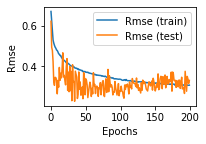

In [15]:
#Plots
from matplotlib import pyplot

pyplot.figure(0)
pyplot.subplot(2, 2, 1)
pyplot.plot(history.history['loss'], label='Rmse (train)')
pyplot.plot(history.history['val_loss'], label='Rmse (test)')
pyplot.ylabel("Rmse")
pyplot.xlabel("Epochs")
pyplot.legend()

